# Imports

In [3]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta

Preprocessing successfully imported.


In [4]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
N = 2500000
training_data = preprocessing.read_data(rows_to_read = N)["train"]
print(training_data.columns)
print(len(training_data.columns))

Reading 2500000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')
19


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Preprocessing the datetime columns

In [5]:
training_data = preprocessing.parse_datetime_columns(training_data)

### Generating target column "delivery_calendar_days"

In [6]:
training_data = preprocessing.create_delivery_calendar_days(training_data)

In [7]:
training_data["delivery_date"].describe()

/tmp/ipykernel_9230/1032584526.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  training_data["delivery_date"].describe()


count                 2500000
unique                    741
top       2018-12-10 00:00:00
freq                     9183
first     2018-01-02 00:00:00
last      2020-02-20 00:00:00
Name: delivery_date, dtype: object

In [8]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 672692
declared_handling_days : 12
acceptance_scan_timestamp : 618965
shipment_method_id : 22
shipping_fee : 4584
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 37521
buyer_zip : 38191
category_id : 33
item_price : 22720
quantity : 85
payment_datetime : 2430469
delivery_date : 741
weight : 817
weight_units : 2
package_size : 5
record_number : 2500000
delivery_calendar_days : 148


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [9]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
}

In [10]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (2500000, 20)
training_data.shape after :  (2500000, 78)


In [11]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [44]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
import numpy as np

In [ ]:
def customLossFunctionTrain(y_true, y_pred):
    PE = 0.4
    PL = 0.6
    early_shipmets_actual_days = y_true[y_true > y_pred]
    early_shipments_predicted_days = y_pred[y_true > y_pred]
    late_shipments_actual_days = y_true[y_true < y_pred]
    late_shipments_predicted_days = y_pred[y_true < y_pred]
    loss = abs((PE * sum(early_shipmets_actual_days - early_shipments_predicted_days)) + (PL * sum(late_shipments_predicted_days - late_shipments_actual_days)))
    return 

In [45]:
def customLossFunctionEval(y_true, y_pred):
    PE = 0.4
    PL = 0.6
    early_shipmets_actual_days = y_true[y_true > y_pred]
    early_shipments_predicted_days = y_pred[y_true > y_pred]
    late_shipments_actual_days = y_true[y_true < y_pred]
    late_shipments_predicted_days = y_pred[y_true < y_pred]
    loss = abs((PE * sum(early_shipmets_actual_days - early_shipments_predicted_days)) + (PL * sum(late_shipments_predicted_days - late_shipments_actual_days)))
    return "Custom Loss Function", np.mean(loss), False

In [13]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((1675000, 67), (825000, 67), (1675000,), (825000,))

In [14]:
model = lgb.LGBMRegressor(learning_rate=0.03,max_depth=-5,random_state=42)
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=10,eval_metric='l2')# This loss needs to mirror the loss that Ebay is using.

/home/monisha/.local/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	training's l2: 9.01128	valid_0's l2: 9.08774
[20]	training's l2: 8.69456	valid_0's l2: 8.76869
[30]	training's l2: 8.51485	valid_0's l2: 8.58991
[40]	training's l2: 8.40765	valid_0's l2: 8.48855
[50]	training's l2: 8.33783	valid_0's l2: 8.42472
[60]	training's l2: 8.29071	valid_0's l2: 8.38587
[70]	training's l2: 8.25818	valid_0's l2: 8.35828
[80]	training's l2: 8.23211	valid_0's l2: 8.33875
[90]	training's l2: 8.21363	valid_0's l2: 8.32358
[100]	training's l2: 8.19775	valid_0's l2: 8.31461


LGBMRegressor(learning_rate=0.03, max_depth=-5, random_state=42)

In [46]:
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=10,eval_metric=customLossFunction)

[10]	training's l2: 9.01128	training's Custom Loss Function: 1.37875e+06	valid_0's l2: 9.08774	valid_0's Custom Loss Function: 679627
[20]	training's l2: 8.69456	training's Custom Loss Function: 1.3523e+06	valid_0's l2: 8.76869	valid_0's Custom Loss Function: 666600
[30]	training's l2: 8.51485	training's Custom Loss Function: 1.3348e+06	valid_0's l2: 8.58991	valid_0's Custom Loss Function: 658014
[40]	training's l2: 8.40765	training's Custom Loss Function: 1.32372e+06	valid_0's l2: 8.48855	valid_0's Custom Loss Function: 652616
[50]	training's l2: 8.33783	training's Custom Loss Function: 1.31622e+06	valid_0's l2: 8.42472	valid_0's Custom Loss Function: 648987
[60]	training's l2: 8.29071	training's Custom Loss Function: 1.31151e+06	valid_0's l2: 8.38587	valid_0's Custom Loss Function: 646757
[70]	training's l2: 8.25818	training's Custom Loss Function: 1.30776e+06	valid_0's l2: 8.35828	valid_0's Custom Loss Function: 644970
[80]	training's l2: 8.23211	training's Custom Loss Function: 1.3

LGBMRegressor(learning_rate=0.03, max_depth=-5, random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

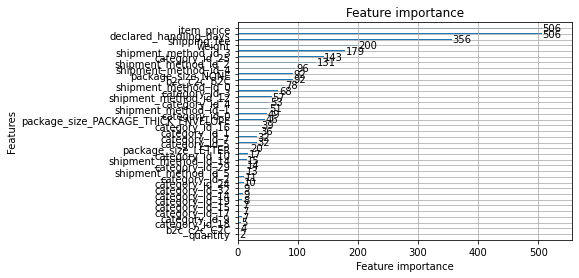

In [38]:
lgb.plot_importance(model)

In [47]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.1443
Testing accuracy 0.1395


In [15]:
# training_data["model_outputs"] = model.predict(training_data[cols_to_use])

In [16]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [17]:
del training_data
quiz_data = preprocessing.read_data(rows_to_read = N)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


Reading 2500000 rows.
Reading all columns.


In [18]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

col :  shipment_method_id_24
col :  shipment_method_id_19
col :  shipment_method_id_21


In [19]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [20]:
output_columns_name = "predicted_delivery_date"

In [ ]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [ ]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [ ]:
import pandas as pd

In [ ]:
submission = pd.read_csv("./results/result_2021-12-19 16:59:16.tsv", sep='\t', header = None)

In [ ]:
submission